In [315]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.manifold import TSNE
from sklearn.model_selection import learning_curve

from scipy.stats import kurtosis

In [309]:
random_state = 2020

X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

X_cred = pd.DataFrame(X_cred)
y_cred = pd.DataFrame(y_cred)

X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.DataFrame(y_mnist)

# mapped_back_to_string_label = mapping.take(results)
y_cred[0], cred_mapping = pd.factorize(y_cred[0])
y_mnist[0], mnist_mapping = pd.factorize(y_mnist[0], sort=True)

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)

X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2,
                                                                            random_state=random_state,
                                                                            stratify=y_mnist)

def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = pd.DataFrame(scaler_cred.transform(X_cred_train), index=y_cred_train.index)
X_cred_test = pd.DataFrame(scaler_cred.transform(X_cred_test), index=y_cred_test.index)

scaler_cred_full = StandardScaler()
scaler_cred_full.fit(X_cred)
X_cred = pd.DataFrame(scaler_cred_full.transform(X_cred), index=y_cred.index)


X_mnist_train = pd.DataFrame(X_mnist_train / 255.0, index=y_mnist_train.index)
X_mnist_test = pd.DataFrame(X_mnist_test / 255.0, index=y_mnist_test.index)
X_mnist = pd.DataFrame(X_mnist / 255.0, index=y_mnist.index)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}
cred_full = {"X": X_cred, "y": y_cred, "name": "Credit Full"}

mnist = {"X": X_mnist_train, "y": y_mnist_train, "name": "MNIST Train"}
mnist_test = {"X": X_mnist_test, "y": y_mnist_test, "name": "MNIST Test"}
mnist_full = {"X": X_mnist, "y": y_mnist, "name": "MNIST Full"}

In [153]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [3]:
def show_digits(data_set, digit_ids, title):
    X, y, name = get_data(data_set)
    
    fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True)
    fig.set_figheight(5)
    fig.set_figwidth(5)
    fig.suptitle(title, fontsize=12)

    image_id = 0
    for i in range(5):
        for j in range(5):
            axes[i][j].imshow(X.loc[image_id, :].values.reshape([28,28]), cmap=plt.get_cmap('gray'))
            axes[i][j].xaxis.set_major_locator(plt.NullLocator())
            axes[i][j].yaxis.set_major_locator(plt.NullLocator())

            image_id += 1

In [4]:
def show_digit(array):
    plt.imshow(array, cmap=plt.get_cmap('gray'))

In [5]:
def cumulative_variance_pca(pca, title, percentile=0.9):
    cum_var = []
    sum = 0
    count = 0
    x_marker = 0
    for ratio in pca.explained_variance_ratio_:
        sum += ratio
        if sum >= percentile:
            x_marker = count
        else:
            count += 1
            
        cum_var.append(sum)

    y_marker = cum_var[x_marker]
    plt.axhline(y=y_marker, linestyle="--", color="red")
    plt.axvline(x=x_marker, linestyle="--", color="red")

    plt.title(title + " - {}% Variance Explained by Top {} Components".format(int(percentile * 100), x_marker))
    plt.plot(range(len(pca.explained_variance_ratio_)), cum_var, label="Cumulative Variance")
    plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Variance")
    plt.ylabel("% Variance Explained")
    plt.xlabel("Top n components used")
    plt.legend(loc="best")
    plt.show()

In [246]:
def two_comp_scatter(X, yDF, title):
    xDF = pd.DataFrame(data=X, index=range(len(X)))
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title(title)

In [7]:
def select_comp_scatter(X, yDF, c1, c2, algo):
    xDF = pd.DataFrame(data=X, index=range(len(X)))
    tempDF = pd.DataFrame(data=xDF.loc[:,[c1, c2]], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations - {}".format(algo))

In [8]:
def dominant_component(comps):
    return {
        "comp, feat": list(zip(range(len(comps)),list(np.argmax(comps, axis=1)))),
        "feat, comp": list(zip(range(len(comps[0])),list(np.argmax(comps, axis=0))))
    }

In [9]:
def mse(data, reconstruction):
    return np.mean(((data - reconstruction) ** 2).values)

In [10]:
def rp_reconstruction(transformed, components):
    return np.dot(transformed, np.linalg.pinv(components.T))

In [11]:
def rp_svm_cross_val(data, n_comp, random_state, scoring):
    X, y, _ = get_data(data)
    
    rp = GaussianRandomProjection(n_components=n_comp, random_state=random_state)
    transformed = rp.fit_transform(X)
    csvm = SVC(C=5,gamma=0.01,kernel='rbf',cache_size=60000,random_state=random_state)
    scores = cross_val_score(csvm, transformed, y, cv=5, scoring=scoring, n_jobs=-1, pre_dispatch="2*n_jobs")
    
    return np.mean(scores)

In [147]:
def dl_svm_cross_val(data, n_comp, random_state, scoring):
    X, y, _ = get_data(data)
    
    dl = MiniBatchDictionaryLearning(n_components=n_comp,alpha=1,batch_size=100,n_iter=25,n_jobs=-1, random_state=random_state)
    transformed = dl.fit_transform(X)
    csvm = SVC(C=5,gamma=0.01,kernel='rbf',cache_size=60000,random_state=random_state)
    scores = cross_val_score(csvm, transformed, y, cv=5, scoring=scoring, n_jobs=-1, pre_dispatch="2*n_jobs")
    
    return np.mean(scores)

In [260]:
def ica_dt_cross_val(data, n_comp, random_state, scoring):
    X, y, _ = get_data(data)
    X, _, y, _ = train_test_split(X, y, test_size=0.5,random_state=random_state,stratify=y)
    ica = FastICA(n_components=i, whiten=True, random_state=random_state, tol=0.0005)
    transformed = ica.fit_transform(X)
    max_depth = 5
    criterion = "entropy"
    ccp_alpha = 0.0001
    min_samples_split = 2 # default
    mtree = DecisionTreeClassifier(max_depth=max_depth,
                                   criterion=criterion,
                                   ccp_alpha=ccp_alpha,
                                   min_samples_split=min_samples_split,
                                   random_state=random_state)
    scores = cross_val_score(mtree, transformed, y, cv=3, scoring=scoring, n_jobs=-1, pre_dispatch="2*n_jobs")
    
    return np.mean(scores)

In [12]:
def rp_comp_error(data, n_comp, runs=10):
    X, y, _ = get_data(data)

    def run(i, error):
        rp = GaussianRandomProjection(n_components=n_comp, random_state=i)
        transformed = rp.fit_transform(X)
        reconstructed = rp_reconstruction(transformed, rp.components_)
        error.append(mse(X, reconstructed))
    
    error = []
    for i in range(runs):
        run(i, error)

    error_mean = np.mean(error)
    error_std = np.std(error)
        
    return (n_comp, error_mean, error_std)

In [87]:
def recon_error_plot(recon_error, title, error=0.1):
    x = [tup[0] for tup in recon_error]
    e_mean = np.array([tup[1] for tup in recon_error])
    e_std = np.array([tup[2] for tup in recon_error])
    
    marker = 0
    for i in range(len(e_mean)):
        if e_mean[i] >= error:
            marker = i
    y_marker = e_mean[marker]
    x_marker = x[marker]
    plt.axhline(y=y_marker, linestyle="--", color="red")
    plt.axvline(x=x_marker, linestyle="--", color="red")
    title += "\n{} Mean Square Error with {} Components".format(round(y_marker, 3), x_marker)
    
    plt.title(title)
    plt.plot(x, e_mean, label="Reconstruction Error", lw=2)
    plt.fill_between(x, e_mean - e_std, e_mean + e_std, alpha=0.1)
    plt.ylabel("MSE")
    plt.xlabel("Components")
    plt.legend(loc="best")
    plt.show()

In [148]:
def print_cross_val(clf, data_set, cv=5, v=1):
    print(clf)
    X, y, name = get_data(data_set)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', verbose=v, n_jobs=-1)
    time.sleep(1)
    print("{} : {}".format(clf.__class__.__name__, name))
    print("Scores: ", scores, "Avg: ", np.mean(scores))

In [149]:
def print_gridsearch(data_set, parameters = {"random_state": random_state}, tuned_parameters={}, scores=["accuracy"]):
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

    best = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(MLPClassifier(**parameters), tuned_parameters, scoring=score, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        best.append((clf.best_score_, clf.best_params_, clf.best_estimator_))
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

    print("Best parameters")
    for i in range(len(best)):
        print(scores[i])
        print(best[i])

In [150]:
def build_learning_curve(clf, data_set, scoring="accuracy", axes=None, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes, return_times=True, random_state=random_state
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")
    plt.show()

In [151]:
def build_confusion_matrix(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    disp = plot_confusion_matrix(clf, X, y, normalize="true", cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

In [244]:
def tSNE_transform(data, perplexity=50, n_iter=1000, scale_down=0.9):
    X = data['X']
    y = data['y']
    
    X, _, y, _ = train_test_split(X, y, test_size=scale_down,random_state=random_state,stratify=y)
    
    return TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, n_jobs=-1).fit_transform(X)

# PCA

In [258]:
Xc, yc, _ = get_data(cred_full)
pca_cred = PCA(n_components=20, random_state=random_state)
X_cred_pca = pca_cred.fit_transform(Xc)

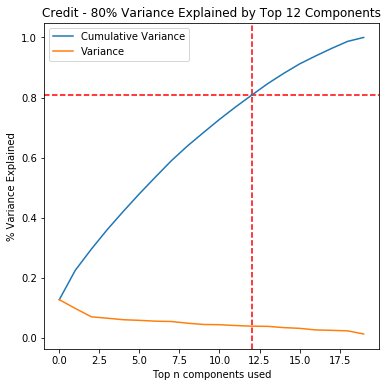

In [72]:
cumulative_variance_pca(pca_cred, "Credit", percentile=0.80)

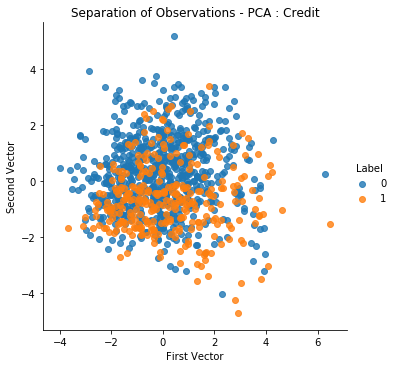

In [73]:
two_comp_scatter(X_cred_pca, yc, "PCA : Credit")

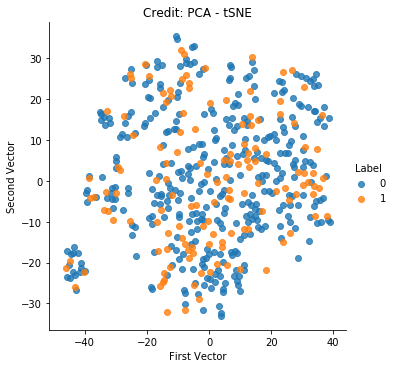

In [259]:
data = {'X': X_cred_pca, 'y': yc}
x_tsne = tSNE_transform(data, perplexity=20, n_iter=5000, scale_down=0.5)
two_comp_scatter(x_tsne, yc, 'Credit: PCA - tSNE')

In [256]:
X, y, _ = get_data(mnist)
pca_mnist = PCA(n_components=153, random_state=random_state)
X_mnist_pca = pca_mnist.fit_transform(X)
X_mnist_pca_test = pca_mnist.transform(mnist_test['X'])

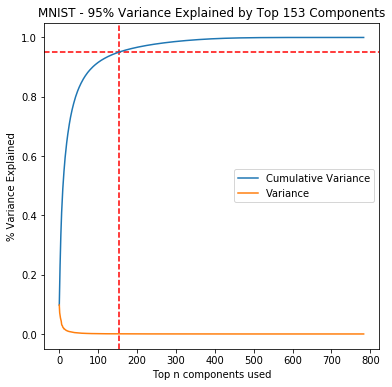

In [103]:
cumulative_variance_pca(pca_mnist, "MNIST", percentile=0.95)

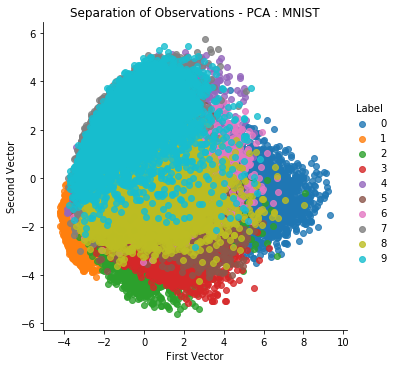

In [76]:
two_comp_scatter(X_mnist_pca, y, "PCA : MNIST")

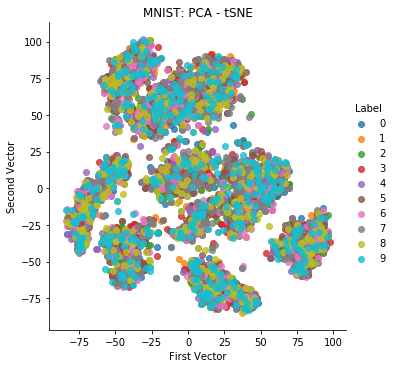

In [257]:
data = {'X': X_mnist_pca, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'MNIST: PCA - tSNE')

In [159]:
# MNIST Neural Network
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
pca_mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
pca_mnn

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [163]:
# Fit
_, ym, _ = get_data(mnist)

pca_mnn = pca_mnn.fit(X_mnist_pca, ym.values.ravel())

In [165]:
print_cross_val(pca_mnn, {'X': X_mnist_pca, 'y': ym, 'name': 'X_mnist_pca'})

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


MLPClassifier : X_mnist_pca
Scores:  [0.97758929 0.97892857 0.97553571 0.97758929 0.97848214] Avg:  0.977625


MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',

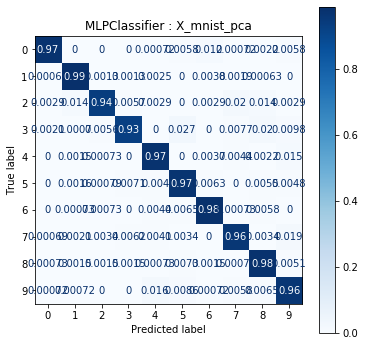

In [168]:
# Test
build_confusion_matrix(pca_mnn, {'X': X_mnist_pca_test, 'y': y_mnist_test, 'name': "X_mnist_pca"})
predicted_mnist = pca_mnn.predict(X_mnist_pca_test)
print("Classification report for classifier %s:\n\n%s\n" % (pca_mnn, classification_report(y_mnist_test, predicted_mnist)))

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


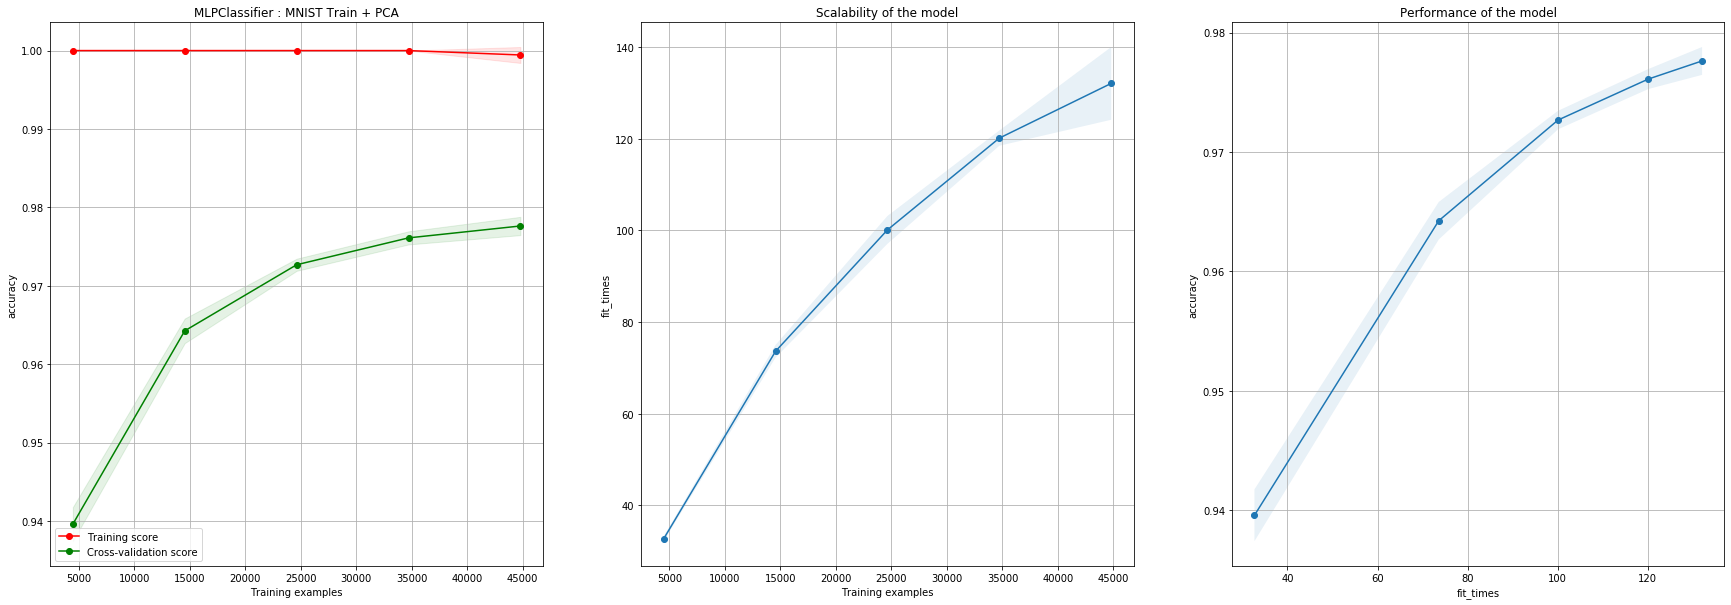

In [317]:
build_learning_curve(pca_mnn, {"X": X_mnist_pca, 'y': y_mnist_train, "name": "MNIST Train + PCA"}, scoring="accuracy")

# ICA

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


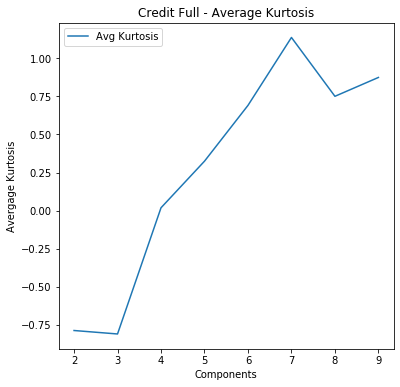

In [77]:
Xc, yc, name = get_data(cred_full)

avg_kurt_cred = []
for i in range(2,10):
    ica_cred = FastICA(n_components=i, whiten=True, random_state=random_state, tol=0.0005)
    ica_cred.fit(Xc)
    mean_kurt = np.mean([kurtosis(x) for x in ica_cred.components_])
    avg_kurt_cred.append(mean_kurt)
    
plt.title(name + " - Average Kurtosis")
plt.plot(range(2, 10), avg_kurt_cred, label="Avg Kurtosis")
plt.ylabel("Avergage Kurtosis")
plt.xlabel("Components")
plt.legend(loc="best")
plt.show()

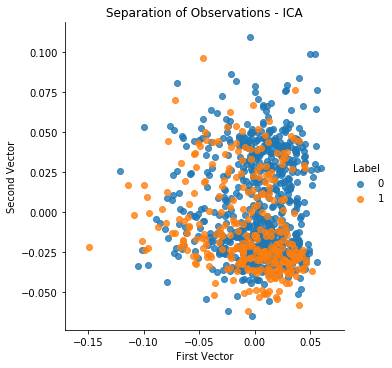

In [78]:
Xc, yc, _ = get_data(cred_full)
ica_cred = FastICA(n_components=7, whiten=True, random_state=random_state, tol=0.005)
X_cred_ica = ica_cred.fit_transform(Xc)
select_comp_scatter(X_cred_ica, yc, 1 ,6, "ICA")

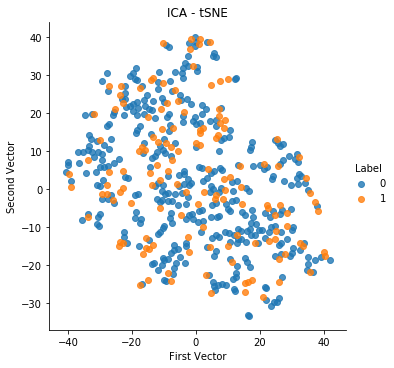

In [248]:
data = {'X': X_cred_ica, 'y': yc}
x_tsne = tSNE_transform(data, perplexity=20, n_iter=5000, scale_down=0.5)
two_comp_scatter(x_tsne, yc, 'ICA - tSNE')

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: Convergenc

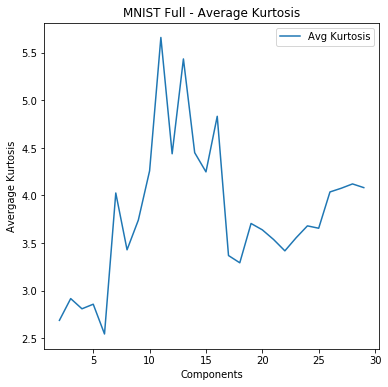

In [79]:
X, y, name = get_data(mnist_full)

avg_kurt = []
for i in range(2,30):
    ica = FastICA(n_components=i, whiten=True, random_state=random_state, max_iter=400, tol=0.0005)
    ica.fit(X)
    mean_kurt = np.mean([kurtosis(x) for x in ica.components_])
    avg_kurt.append(mean_kurt)
    
plt.title(name + " - Average Kurtosis")
plt.plot(range(2, 30), avg_kurt, label="Avg Kurtosis")
plt.ylabel("Avergage Kurtosis")
plt.xlabel("Components")
plt.legend(loc="best")
plt.show()

In [ ]:
X, y, name = get_data(mnist)

avg_kurt = []
for i in range(2,784):
    ica = FastICA(n_components=i, whiten=True, random_state=random_state, max_iter=400, tol=0.0005)
    ica.fit(X)
    mean_kurt = np.mean([kurtosis(x) for x in ica.components_])
    avg_kurt.append(mean_kurt)
    
plt.title(name + " - Average Kurtosis")
plt.plot(range(2, 30), avg_kurt, label="Avg Kurtosis")
plt.ylabel("Avergage Kurtosis")
plt.xlabel("Components")
plt.legend(loc="best")
plt.show()

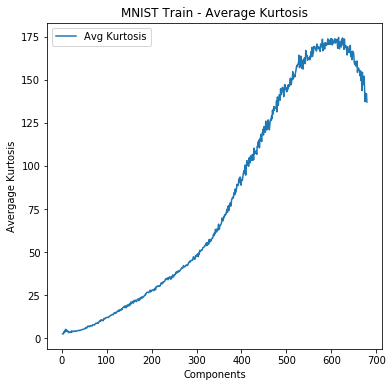

In [296]:
plt.title(name + " - Average Kurtosis")
plt.plot(range(2, 680), [avg_kurt[i] for i in range(2,680)], label="Avg Kurtosis")
plt.ylabel("Avergage Kurtosis")
plt.xlabel("Components")
plt.legend(loc="best")
plt.show()

In [297]:
np.array([avg_kurt[i] for i in range(2,680)]).argmax()

614

In [298]:
Xm, ym, _ = get_data(mnist_full)
ica_mnist = FastICA(n_components=600, whiten=True, random_state=random_state, max_iter=400, tol=0.0005)
X_mnist_ica = ica_mnist.fit_transform(Xm)
X_mnist_ica_test = ica_mnist.fit_transform(X_mnist_test)

In [ ]:
X = ica_mnist.transform(X_mnist_train)

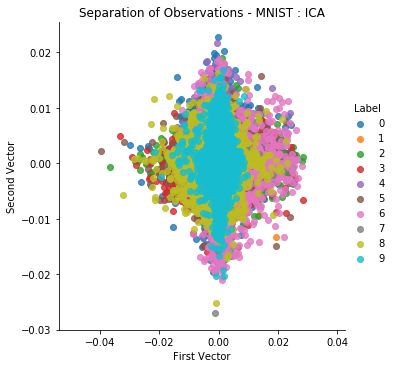

In [224]:
select_comp_scatter(X_mnist_ica, ym, 13, 50, "MNIST : ICA")

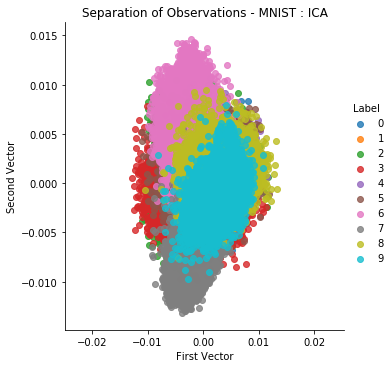

In [169]:
Xm, ym, _ = get_data(mnist_full)
ica_mnist = FastICA(n_components=10, whiten=True, random_state=random_state, max_iter=400, tol=0.0005)
X_mnist_ica = ica_mnist.fit_transform(Xm)
X_mnist_ica_test = ica_mnist.fit_transform(X_mnist_test)
select_comp_scatter(X_mnist_ica, ym, 2, 9, "MNIST : ICA")

In [300]:
Xm, ym, _ = get_data(mnist_full)
ica_mnist = FastICA(n_components=11, whiten=True, random_state=random_state, max_iter=400, tol=0.0005)
X_mnist_ica = ica_mnist.fit_transform(Xm)

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [307]:
X_mnist_ica_test = ica_mnist.fit_transform(X_mnist_test)

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


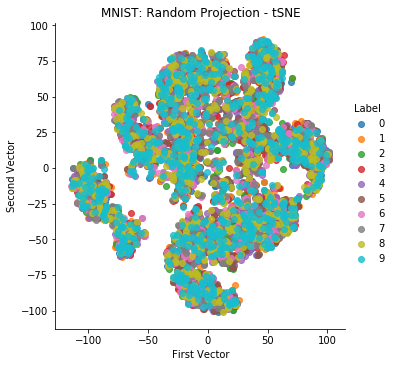

In [301]:
data = {'X': X_mnist_ica, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'MNIST: Random Projection - tSNE')

In [302]:
# MNIST Neural Network
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
ica_mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
ica_mnn

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [304]:
# Fit
_, ym, _ = get_data(mnist_full)

ica_mnn = ica_mnn.fit(X_mnist_ica, ym.values.ravel())

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [305]:
print_cross_val(pca_mnn, {'X': X_mnist_ica, 'y': ym, 'name': 'X_mnist_ica'})

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.4min finished


MLPClassifier : X_mnist_ica
Scores:  [0.93778571 0.93785714 0.93985714 0.93735714 0.94307143] Avg:  0.9391857142857143


MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',

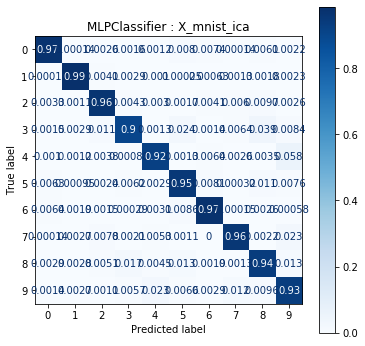

In [313]:
# Test
build_confusion_matrix(ica_mnn, {'X': X_mnist_ica, 'y': ym, 'name': 'X_mnist_ica'})
predicted_mnist = ica_mnn.predict(X_mnist_ica_test)
print("Classification report for classifier %s:\n\n%s\n" % (ica_mnn, classification_report(y_mnist_test, predicted_mnist)))

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


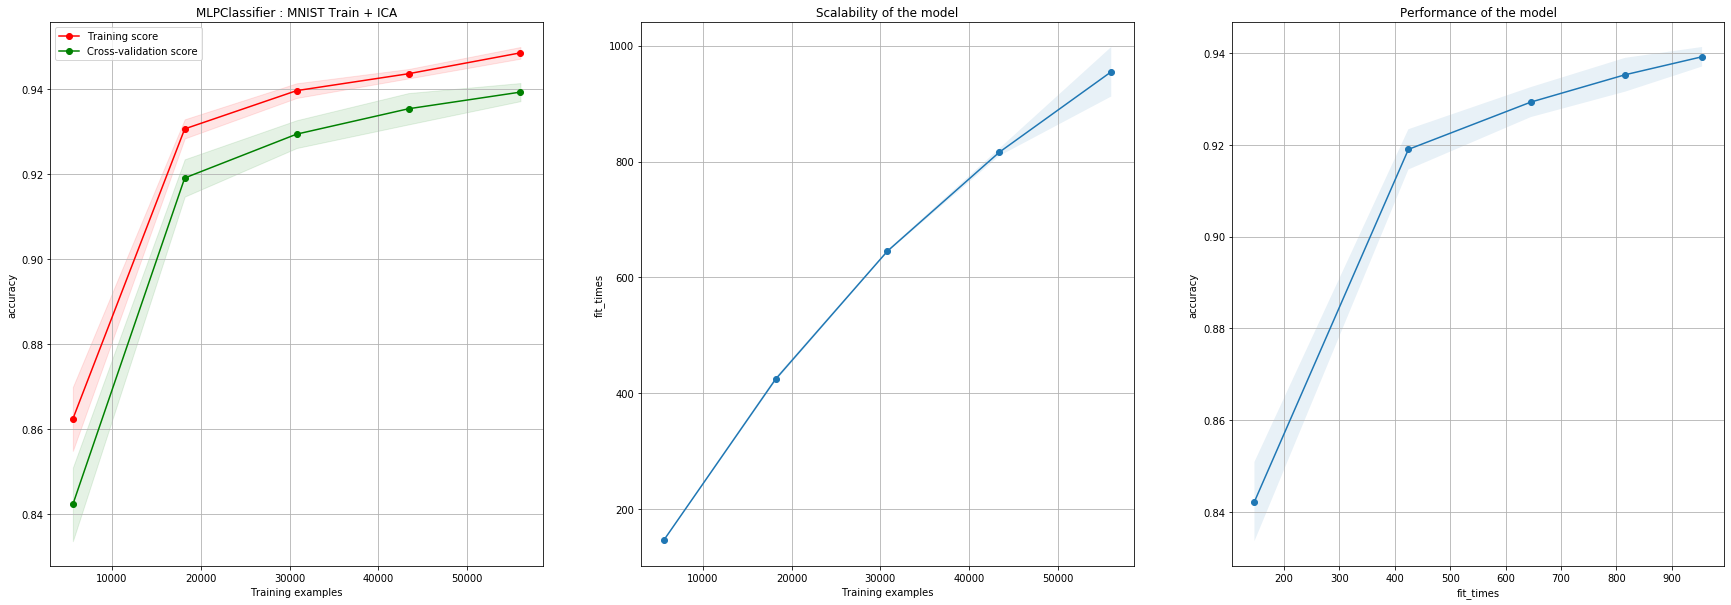

In [319]:
build_learning_curve(ica_mnn, {"X": X_mnist_ica, 'y': ym, "name": "MNIST Train + ICA"}, scoring="accuracy")

# Random Projection

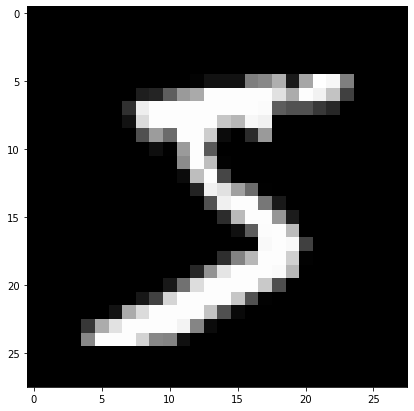

In [94]:
Xc, yc, _ = get_data(cred_full)
rp = GaussianRandomProjection(n_components=7,
                              random_state=random_state)
rp_cred = rp.fit_transform(Xc)
Xc
show_digit(mnist['X'].loc[0,:].values.reshape([28,28]))

In [106]:
Xc, yc, _ = get_data(cred_full)
rp = GaussianRandomProjection(n_components=7,
                              random_state=random_state)
rp_cred = rp.fit_transform(Xc)
d = np.dot(Xc, rp.components_.T)
r = np.dot(d, np.linalg.pinv(rp.components_.T))
loss = np.mean(((Xc - r) ** 2).values)
mse(Xc, r)

0.6587441855053309

In [91]:
# Credit reconstruction error
cred_recon_error =[rp_comp_error(cred_full, i, runs=20) for i in range(2, 21)]

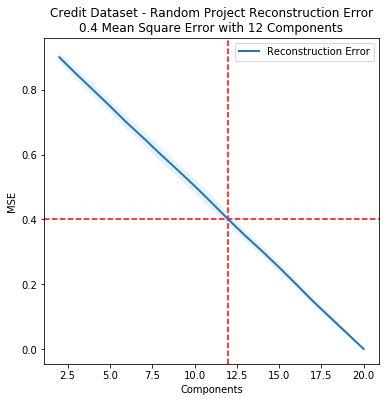

In [90]:
recon_error_plot(cred_recon_error, "Credit Dataset - Random Project Reconstruction Error", error=0.39)

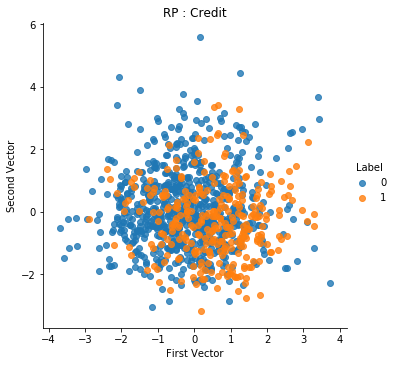

In [249]:
Xc, yc, _ = get_data(cred_full)
cred_rp = GaussianRandomProjection(n_components=12, random_state=random_state)
X_cred_rp = cred_rp.fit_transform(Xc)
two_comp_scatter(X_cred_rp, yc, "RP : Credit")

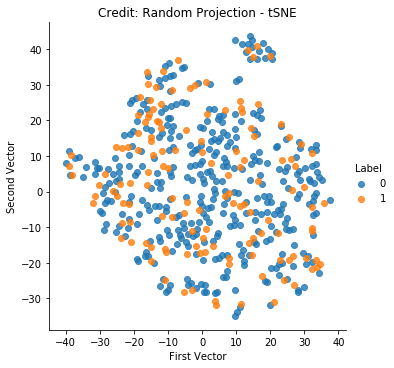

In [250]:
data = {'X': X_cred_rp, 'y': yc}
x_tsne = tSNE_transform(data, perplexity=20, n_iter=5000, scale_down=0.5)
two_comp_scatter(x_tsne, yc, 'Credit: Random Projection - tSNE')

In [ ]:
# MNIST Reconstruction Error
mnist_recon_error = [rp_comp_error(mnist, i, runs=5) for i in range(2, 784)]

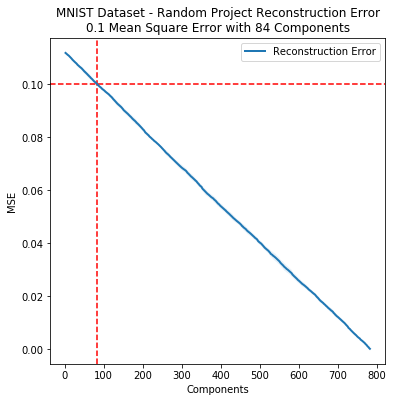

In [104]:
recon_error_plot(mnist_recon_error, "MNIST Dataset - Random Project Reconstruction Error")

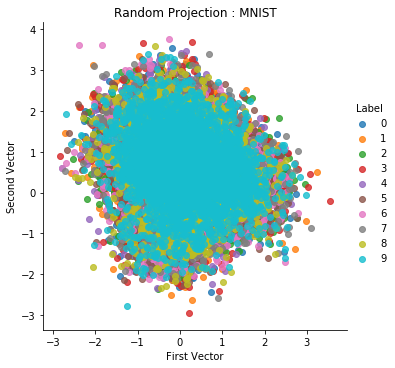

In [254]:
Xm, ym, _ = get_data(mnist)
mnist_rp = GaussianRandomProjection(n_components=84, random_state=random_state)
X_mnist_rp = mnist_rp.fit_transform(Xm)
X_mnist_rp_test = mnist_rp.transform(X_mnist_test)

two_comp_scatter(X_mnist_rp, ym, "Random Projection : MNIST")

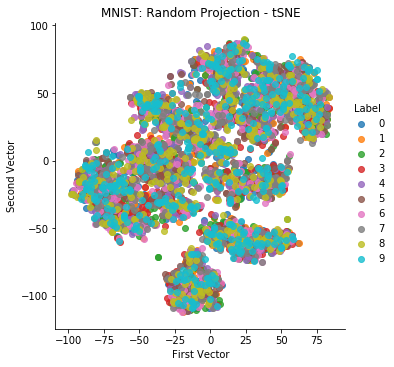

In [255]:
data = {'X': X_mnist_rp, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'MNIST: Random Projection - tSNE')

In [199]:
# MNIST Neural Network
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
rp_mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
rp_mnn

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [200]:
# Fit
_, ym, _ = get_data(mnist)

rp_mnn = rp_mnn.fit(X_mnist_rp, ym.values.ravel())

In [228]:
print_cross_val(rp_mnn, {'X': X_mnist_rp, 'y': ym, 'name': 'X_mnist_rp'})

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


MLPClassifier : X_mnist_rp
Scores:  [0.96803571 0.97223214 0.97       0.9625     0.97035714] Avg:  0.968625


MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',

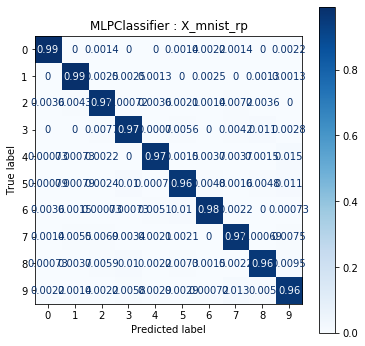

In [202]:
# Test
build_confusion_matrix(rp_mnn, {'X': X_mnist_rp_test, 'y': y_mnist_test, 'name': 'X_mnist_rp'})
predicted_mnist = rp_mnn.predict(X_mnist_rp_test)
print("Classification report for classifier %s:\n\n%s\n" % (rp_mnn, classification_report(y_mnist_test, predicted_mnist)))

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


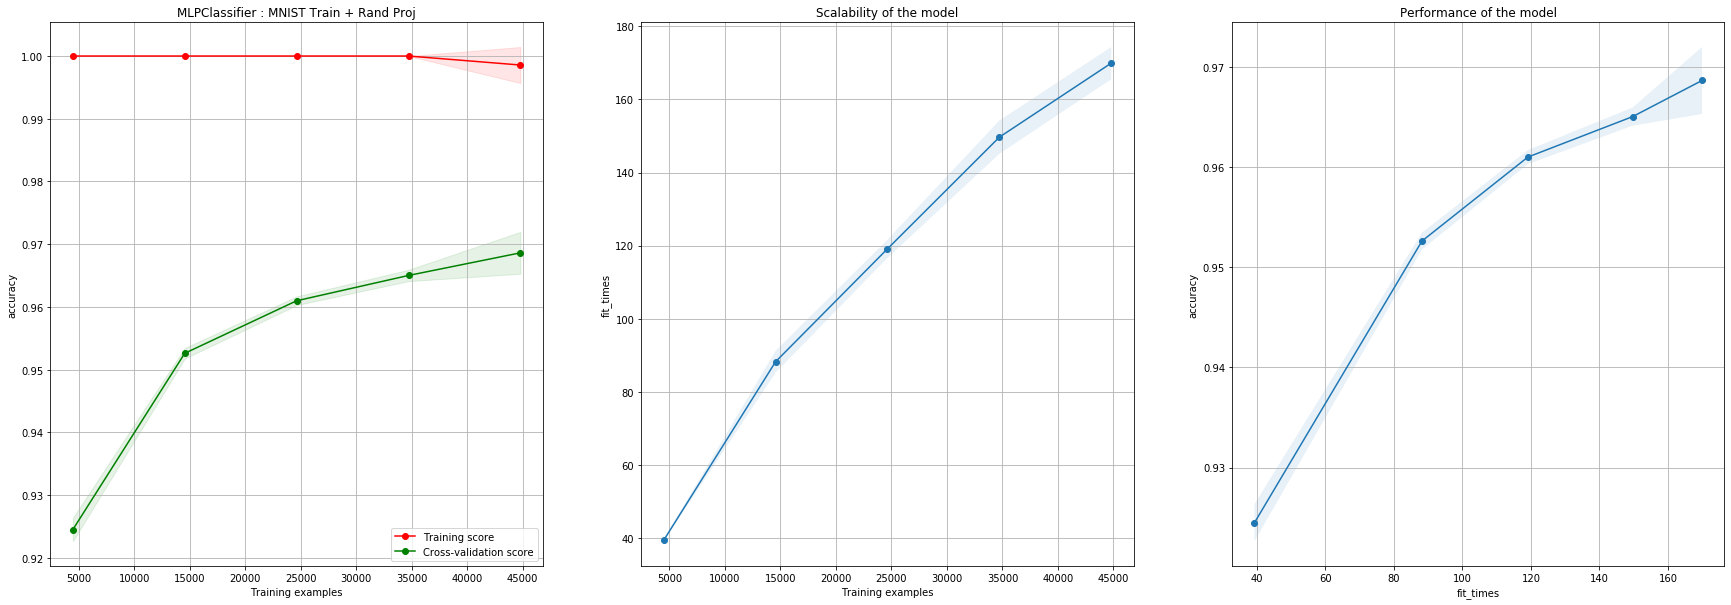

In [323]:
build_learning_curve(rp_mnn, {"X": X_mnist_rp, 'y': y_mnist_train, "name": "MNIST Train + Rand Proj"}, scoring="accuracy")

# Dictionary Learning

In [251]:
Xc, yc, _ = get_data(cred_full)

dl = MiniBatchDictionaryLearning(n_components=11,
                                 alpha=1,
                                 batch_size=100,
                                 n_iter=25,
                                 random_state=random_state)
cred_dl = dl.fit_transform(Xc)

In [145]:
cred_dl_svm = [dl_svm_cross_val(cred_full, i, random_state, "f1") for i in range(2, 21)]

In [229]:
np.array(cred_dl_svm).argmax()

11

<function matplotlib.pyplot.show(*args, **kw)>

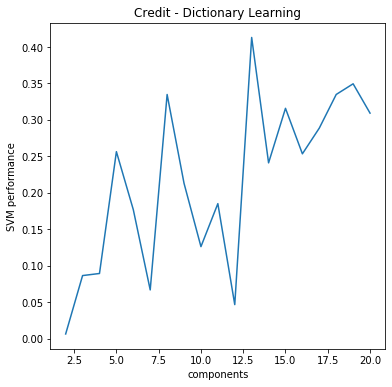

In [231]:
plt.plot(range(2,21), dl_svm)
plt.title("Credit - Dictionary Learning")
plt.ylabel("SVM performance")
plt.xlabel("components")
plt.show

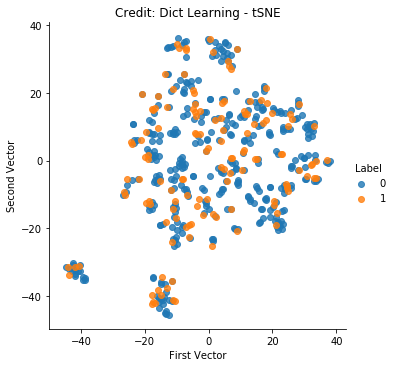

In [252]:
data = {'X': cred_dl, 'y': yc}
x_tsne = tSNE_transform(data, perplexity=20, n_iter=5000, scale_down=0.5)
two_comp_scatter(x_tsne, yc, 'Credit: Dict Learning - tSNE')

In [177]:
mnist_dl_svm = [dl_svm_cross_val(mnist, i, random_state, "accuracy") for i in range(2, 50)]

In [204]:
Xm, ym, _ = get_data(mnist)

dl = MiniBatchDictionaryLearning(n_components=22,
                                 alpha=1,
                                 batch_size=100,
                                 n_iter=25,
                                 random_state=random_state)
X_mnist_dl = dl.fit_transform(Xm)
X_mnist_dl_test = dl.transform(X_mnist_test)

<function matplotlib.pyplot.show(*args, **kw)>

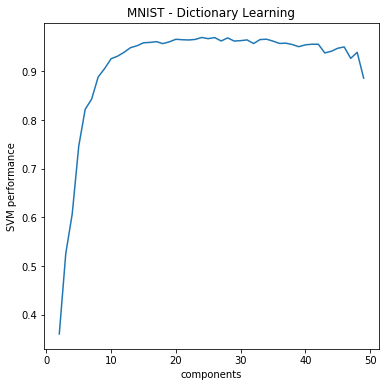

In [225]:
plt.plot(range(2,50), mnist_dl_svm)
plt.title("MNIST - Dictionary Learning")
plt.ylabel("SVM performance")
plt.xlabel("components")
plt.show

In [203]:
np.array(mnist_dl_svm).argmax()

22

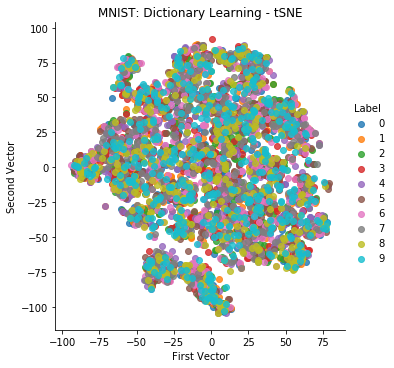

In [253]:
data = {'X': X_mnist_dl, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'MNIST: Dictionary Learning - tSNE')

In [205]:
# MNIST Neural Network
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
dl_mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
dl_mnn

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [206]:
# Fit
_, ym, _ = get_data(mnist)

dl_mnn = dl_mnn.fit(X_mnist_dl, ym.values.ravel())

In [230]:
print_cross_val(dl_mnn, {'X': X_mnist_dl, 'y': ym, 'name': 'X_mnist_dl'})

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


MLPClassifier : X_mnist_dl
Scores:  [0.96607143 0.97392857 0.96830357 0.97151786 0.97205357] Avg:  0.970375


MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',

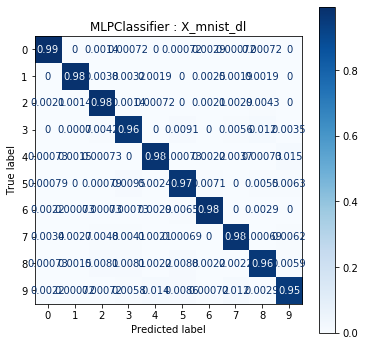

In [208]:
# Test
build_confusion_matrix(dl_mnn, {'X': X_mnist_dl_test, 'y': y_mnist_test, 'name': 'X_mnist_dl'})
predicted_mnist = dl_mnn.predict(X_mnist_dl_test)
print("Classification report for classifier %s:\n\n%s\n" % (dl_mnn, classification_report(y_mnist_test, predicted_mnist)))

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


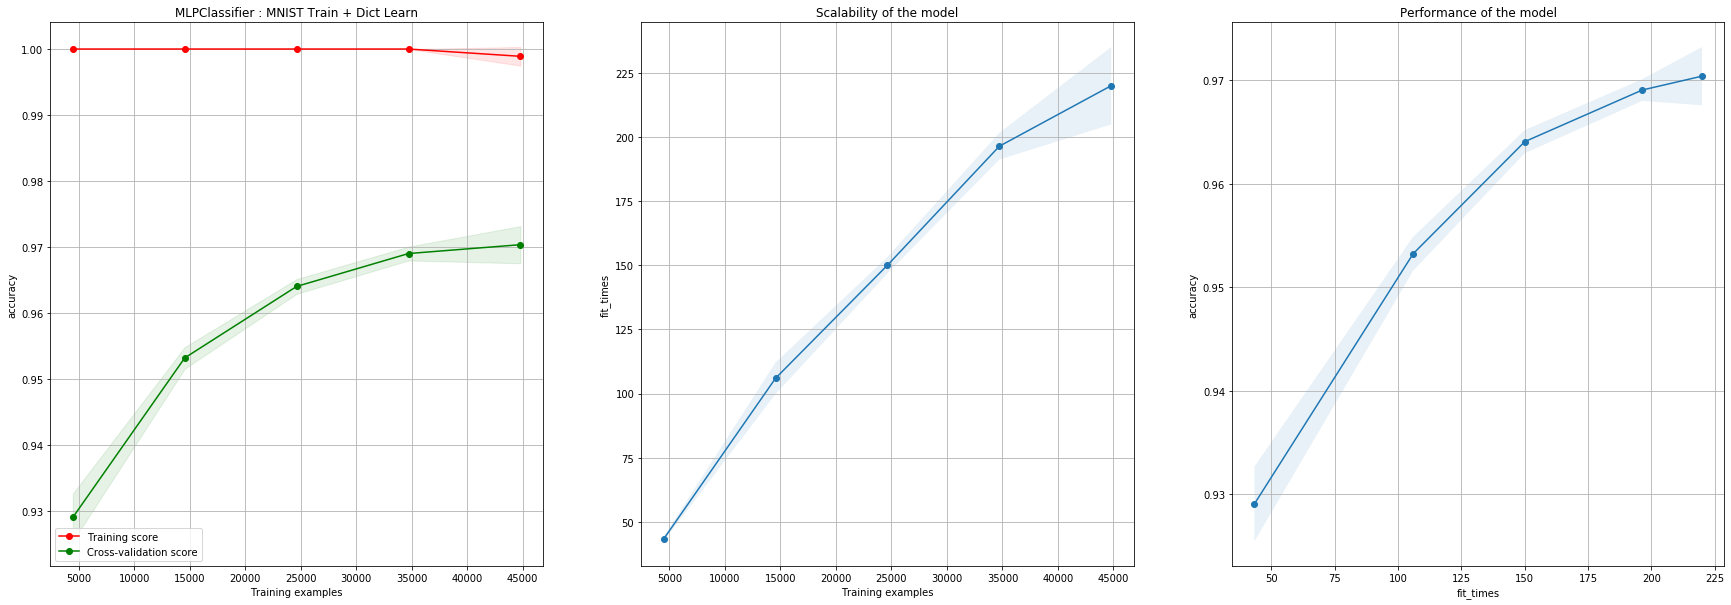

In [318]:
build_learning_curve(dl_mnn, {"X": X_mnist_dl, 'y': y_mnist_train, "name": "MNIST Train + Dict Learn"}, scoring="accuracy")